#Using integer programming and portfolio optimization to pick a March Madness bracket

In this notebook I explore the use of an [integer program](http://en.wikipedia.org/wiki/Integer_programming) solver in Python to pick an optimal March Madness bracket.

I use the [cvxopt](http://cvxopt.org/) Python interface to the [glpk](https://www.gnu.org/software/glpk/) solver, both freely available. I also use pandas and numpy. Installing cvxopt and glpk was simple but not completely straightforward; see the appendix at the end for how I did it.

## Scoring
The pool I was invited to had an interesting set of rules. You ignore the brackets and simply choose teams, but each team has a price and you have a limited budget:

>Pick any set of teams you want as long as you stay within your $2000 budget. And all of your teams earn you points as long as they're still in the tournament.
```
0 points for play-in wins
1 point for every first round win
2 points for every second round win
3 points for every third round win
5 points for every quarterfinal win
8 points for every semifinal win
13 points for a finals win
```

>Pricing structure:
```
1 seeds: $500
2 seeds: $300
3 seeds: $225
4 seeds: $175
5 seeds: $125
6 seeds: $125
7 seeds: $95
8 seeds: $85
9 seeds: $60
10 seeds: $65
11 seeds: $60
12 seeds: $55
13 seeds: $25
14 seeds: $20
15 seeds: $5
16 seeds: $1```

I'm not sure if the price for 9 seeds was a typo.

## Data

[fivethirtyeight.com](fivethirtyeight.com) (Nate Silver's website) has a model for the tournament and provided [data](https://github.com/fivethirtyeight/data/tree/master/march-madness-predictions-2015) on the output of that model. The data includes the predicted probability that each team will win in each round, which is what we're after. I selected the most recent data set after all the play-in games had completed.

In [7]:
data = pd.read_csv('bracket-05.tsv', sep='\t')
data = data.\
    query('rd1_win > 0').\
    rename(columns=dict(rd1_win=1, rd2_win=2, rd3_win=3, rd4_win=4, rd5_win=5, rd6_win=6, rd7_win=7))\
    [['team_name', 'team_seed', 1, 2, 3, 4, 5, 6, 7]]
data.head()

,team_name,team_seed,1,2,3,4,5,6,7
0,Kentucky,1,1,0.998983,0.940664,0.855849,0.732191,5.351611e-01,4.131957e-01
2,Hampton,16b,1,0.001017,0.000103,0.000012,0.000001,5.387219e-08,4.307362e-09
3,Cincinnati,8,1,0.536887,0.034189,0.017280,0.007178,2.065072e-03,7.358615e-04
4,Purdue,9,1,0.463113,0.025044,0.012093,0.004774,1.382256e-03,4.958285e-04
5,West Virginia,5,1,0.682463,0.392345,0.052872,0.025248,7.441731e-03,2.693933e-03


The numbered columns represent the probability that a team will win in that round of the tournament. This of course means that they had to win all previous rounds, so you can see that the numbers are always decreasing from left to right.

I found it useful to think about the score you get from each team as a discrete random variable. In this case we need to change the above probabilities so that they represent the chance of winning exactly that number of games, so that for each team the sum of probabilities is 1.

In [8]:
data[8] = 0
for col in range(8, 1, -1):
    data[col] = data[col-1] - data[col]
data = data.drop(labels=1, axis=1)
data = data.rename(columns=dict(zip(range(2,9), range(7))))
data.head()

,team_name,team_seed,0,1,2,3,4,5,6
0,Kentucky,1,0.001017,0.058320,0.084815,0.123658,0.197030,1.219654e-01,4.131957e-01
2,Hampton,16b,0.998983,0.000913,0.000091,0.000011,0.000001,4.956483e-08,4.307362e-09
3,Cincinnati,8,0.463113,0.502698,0.016909,0.010102,0.005113,1.329211e-03,7.358615e-04
4,Purdue,9,0.536887,0.438069,0.012951,0.007319,0.003392,8.864273e-04,4.958285e-04
5,West Virginia,5,0.317537,0.290118,0.339473,0.027624,0.017807,4.747797e-03,2.693933e-03


Now we set up the data for the scoring rules of the pool:

In [9]:
rounds = range(7)
scores = [0, 1, 2, 3, 5, 8, 13]
cumscores = np.cumsum(scores)
prices =   {'1': 500,
            '2': 300,
            '3': 225,
            '4': 175,
            '5': 125,
            '6': 125,
            '7': 95,
            '8': 85,
            '9': 60,
            '10': 65,
            '11': 60,
            '11a': 60,
            '11b': 60,
            '12': 55,
            '13': 25,
            '14': 20,
            '15': 5,
            '16': 1,
            '16a': 1,
            '16b': 1}
budget = 2000
n = len(data)
data['price'] = [prices[seed] for seed in data.team_seed]

A few quantities which we'll be interested in are:

* The expected score for each team. This is the average of the number of points for winning each possible number of games (0 through 6), weighted by the probability of winning that number of games.
* The variance of the score for each team.
* What I call the efficiency of each team. This is simply the expected score divided by the price.

In [10]:
def get_expected_score(team):
    return sum(team[r]*cumscores[r] for r in rounds)
data['expected_score'] = data.apply(get_expected_score, axis=1)

def get_variance(team):
    return sum(team[r]*(cumscores[r]-team['expected_score'])**2 for r in rounds)
data['variance'] = data.apply(get_variance, axis=1)

data['efficiency'] = data.expected_score/data.price

In [11]:
cols = ['team_name', 'team_seed', 'price', 'expected_score', 'variance', 'efficiency']
data[cols].sort(columns=['efficiency'], ascending=False).head()

,team_name,team_seed,price,expected_score,variance,efficiency
0,Kentucky,1,500,18.761645,144.256509,0.037523
16,New Mexico State,15,5,0.166190,0.390123,0.033238
39,Utah,5,125,4.123377,27.834924,0.032987
32,Arizona,2,300,9.649058,76.986045,0.032164
36,Robert Morris,16b,1,0.027626,0.065626,0.027626


## Choosing the optimal set of teams

### Maximizing expected score

A naive approach to maximizing the expected score is to continue adding the most efficient remaining team to your list until you run out of budget. But this could leave you with a little bit of unused budget. You might be better off sacrificing a little bit of efficiency so that you can spend your whole budget and get a higher total expected score.

In fact this is an example of the [knapsack problem](http://en.wikipedia.org/wiki/Knapsack_problem) which is known to be NP-hard. There are specialized algorithms that solve the knapsack problem, but this is a particularly easy one and I wanted to play with the available free Python integer program solvers.

### You don't actually want that

But that isn't necessarily the best way to maximize either your chance of winning or your expected earnings from the pool, which are more likely to be what you actually want. The right way to do it probably involves understanding how large and diverse your competition is, and throwing in some unpopular picks without sacrificing much efficiency. I don't know how to do that though.

### Add in a risk penalty

But even if your goal is something like "get a lot of points in this tournament", picking the set of teams with the largest EV isn't necessarily the right play. The max-EV-set could be very risky in that it's expected to get a bad score most of the time, but occasionally gets a huge score, so that on average the score is pretty high. You might be willing to sacrifice a bit of EV in exchange for reduced risk.

A method for doing this from portfolio optimization is to maximize the expected return plus a variance penalty. You can tune the variance penalty based on your risk tolerance, setting it to zero to get the usual max-EV-set.

### Notation

The problem I'll solve can be written as follows:

$$ \max_x \left\{ \mu^T x - \epsilon v^T x : p^T x \leq B, x \in \{0,1\} \right\} $$

The optimization variable is $x$, which is a binary vector of length 64. Each element represents a team, with a 1 indicating that you select that team to be in your set.

$\mu$ is the vector of expected scores for each team, $v$ the variance, and $p$ the price. $B$ is the budget, 2000 in this case. $\epsilon$ is the risk penalty factor.

##Solving the optimization problem

I'll use the integer linear program solver `ilp` from glpk. I use the cvxopt Python interface to glpk to access it.

In [12]:
from cvxopt import matrix
from cvxopt.glpk import ilp

In [16]:
def solve_binary_program(eps):
    """
    Uses the integer linear program solver ilp from glpk:

    (status, x) = ilp(c, G, h, A, b, I, B)

        minimize    c'*x
        subject to  G*x <= h
                    A*x = b
                    x[k] is integer for k in I
                    x[k] is binary for k in B

    c            nx1 dense 'd' matrix with n>=1
    G            mxn dense or sparse 'd' matrix with m>=1
    h            mx1 dense 'd' matrix
    A            pxn dense or sparse 'd' matrix with p>=0
    b            px1 dense 'd' matrix
    I            set of indices of integer variables
    B            set of indices of binary variables
    """
    c = data.expected_score - eps*data.variance
    c = matrix(c)
    G = matrix(data.price[:, np.newaxis].T, tc='d')
    h = matrix(budget, tc='d')
    A = matrix(np.zeros((1, n)), tc='d')
    b = matrix(0.)
    I = set(range(n))
    B = set(range(n))

    (status, x) = ilp(-c, G, h, A, b, I, B)
    if status != 'optimal':
        raise
    return x

## Results

Notice how as we increase the risk penalty, the optimal set of teams increases in size. And of course, both the expected score and the total variance decrease.

In [20]:
def solve_and_display(eps=0):
    x = solve_binary_program(eps)
    print('number of teams', sum(x))

    data['selected'] = x
    expected_score = data[data.selected == 1].expected_score.sum()
    total_variance = data[data.selected == 1].variance.sum()
    print('expected score %.2f' % expected_score)
    print('total variance %.2f' % total_variance)
    return data\
        [data.selected == 1]\
        [['team_name', 'team_seed', 'price', 'expected_score', 'variance', 'efficiency']].\
        sort(columns='price', ascending=False)

The maximum expected score solution:

In [21]:
solve_and_display()

number of teams 15.0
expected score 57.23
total variance 441.66


,team_name,team_seed,price,expected_score,variance,efficiency
0,Kentucky,1,500,18.761645,144.256509,0.037523
51,Villanova,1,500,10.798966,90.892268,0.021598
32,Arizona,2,300,9.649058,76.986045,0.032164
66,Virginia,2,300,7.598104,71.553645,0.025327
39,Utah,5,125,4.123377,27.834924,0.032987
13,Wichita State,7,95,2.275967,11.880365,0.023958
31,Ohio State,10,65,1.350079,8.044640,0.020770
10,Texas,11,60,1.499421,7.395559,0.024990
8,Valparaiso,13,25,0.481423,1.126213,0.019257
29,Georgia State,14,20,0.453335,1.129402,0.022667


With just a little bit of risk penalty, Villanova drops out of the optimal set. The extra 500 of budget is spent on Gonzaga, North Carolina, and UC Irvine, with only a tiny loss of expected score.

Either this set of teams or the next one might be good choices for the pool, since they expect to get close to the same score without quite as much variance.

In [22]:
solve_and_display(eps=.03)

number of teams 17.0
expected score 56.87
total variance 416.10


,team_name,team_seed,price,expected_score,variance,efficiency
0,Kentucky,1,500,18.761645,144.256509,0.037523
32,Arizona,2,300,9.649058,76.986045,0.032164
49,Gonzaga,2,300,6.418647,44.254151,0.021395
66,Virginia,2,300,7.598104,71.553645,0.025327
23,North Carolina,4,175,3.598615,20.148501,0.020564
39,Utah,5,125,4.123377,27.834924,0.032987
13,Wichita State,7,95,2.275967,11.880365,0.023958
31,Ohio State,10,65,1.350079,8.044640,0.020770
10,Texas,11,60,1.499421,7.395559,0.024990
8,Valparaiso,13,25,0.481423,1.126213,0.019257


Increasing the risk penalty typically increases the number of teams in the optimal set, spreading the eggs across many baskets to mitigate risk. But the relationship isn't strictly monotone as we see here, going down from 17 to 16 teams after increasing $\epsilon$ from .03 to .05:

In [26]:
solve_and_display(eps=.05)

number of teams 16.0
expected score 54.39
total variance 364.04


,team_name,team_seed,price,expected_score,variance,efficiency
0,Kentucky,1,500,18.761645,144.256509,0.037523
32,Arizona,2,300,9.649058,76.986045,0.032164
49,Gonzaga,2,300,6.418647,44.254151,0.021395
23,North Carolina,4,175,3.598615,20.148501,0.020564
39,Utah,5,125,4.123377,27.834924,0.032987
55,Northern Iowa,5,125,2.231097,10.160632,0.017849
13,Wichita State,7,95,2.275967,11.880365,0.023958
31,Ohio State,10,65,1.350079,8.044640,0.020770
10,Texas,11,60,1.499421,7.395559,0.024990
20,Oklahoma State,9,60,0.947926,2.718533,0.015799


In [27]:
solve_and_display(eps=.1)

number of teams 26.0
expected score 45.79
total variance 268.87


,team_name,team_seed,price,expected_score,variance,efficiency
0,Kentucky,1,500,18.761645,144.256509,0.037523
23,North Carolina,4,175,3.598615,20.148501,0.020564
21,Arkansas,5,125,1.669730,5.633805,0.013358
55,Northern Iowa,5,125,2.231097,10.160632,0.017849
5,West Virginia,5,125,1.846568,7.557176,0.014773
39,Utah,5,125,4.123377,27.834924,0.032987
13,Wichita State,7,95,2.275967,11.880365,0.023958
37,San Diego State,8,85,1.036467,4.378130,0.012194
31,Ohio State,10,65,1.350079,8.044640,0.020770
44,UCLA,11,60,0.716904,2.787515,0.011948


As we increase the risk penalty even further, the optimization problem no longer really suits our purpose. It becomes so afraid of risk that it spends far below the budget, choosing mostly terrible teams that are likely to lose in the first round, contributing very little uncertainty to our result, but also very little value.

In [47]:
solve_and_display(eps=.4)

number of teams 14.0
expected score 3.00
total variance 6.62


,team_name,team_seed,price,expected_score,variance,efficiency
22,Wofford,12,55,0.332589,0.586285,0.006047
56,Wyoming,12,55,0.439177,1.026169,0.007985
8,Valparaiso,13,25,0.481423,1.126213,0.019257
42,Eastern Washington,13,25,0.301771,0.500441,0.012071
58,UC Irvine,13,25,0.421511,0.925401,0.016860
12,Northeastern,14,20,0.153953,0.360553,0.007698
29,Georgia State,14,20,0.453335,1.129402,0.022667
63,Albany,14,20,0.149620,0.355647,0.007481
16,New Mexico State,15,5,0.166190,0.390123,0.033238
33,Texas Southern,15,5,0.008298,0.014673,0.001660


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

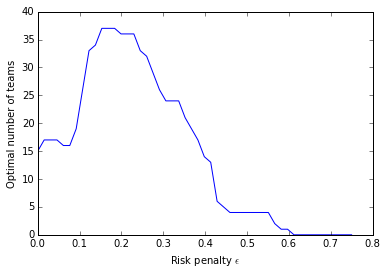

In [53]:
f = lambda eps: sum(solve_binary_program(eps))
eps = np.linspace(0, .75)
num_teams = [f(_) for _ in eps]
plt.plot(eps, num_teams)
plt.ylim(0, 40)
plt.xlabel('Risk penalty $\epsilon$')
plt.ylabel('Optimal number of teams');

<hr>

#Appendix

##Installing cvxopt and glpk

I think this should do the trick.

### Ubuntu

```
sudo apt-get install libglpk36

export CVXOPT_BUILD_GLPK=1
export CVXOPT_GLPK_LIB_DIR=/usr/lib/x86_64-linux-gnu/
export CVXOPT_GLPK_INC_DIR=/usr/include/
pip install cvxopt

python
> from cvxopt.glpk import ilp
```

### Mac

```
brew install homebrew/science/glpk

export CVXOPT_BUILD_GLPK=1
export CVXOPT_GLPK_LIB_DIR=/usr/local/Cellar/glpk/4.52/lib
export CVXOPT_GLPK_INC_DIR=/usr/local/Cellar/glpk/4.52/include
pip install cvxopt

python
> from cvxopt.glpk import ilp
```